In [70]:
import pandas as pd
import numpy as np

from scipy import stats

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

In [71]:
plt.style.use("seaborn-whitegrid")

C:\Users\Benny Boi\AppData\Local\Temp\ipykernel_8864\3963306264.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


In [72]:
pd.options.display.max_columns = 500
pd.options.display.max_rows = 4000

# Feature Engineering

This notebook will cover the following topics

    -determine which features are the most important with mutual information
    -invent new features in several real-world problem domains
    -encode high-cardinality categoricals with a target encoding
    -create segmentation features with k-means clustering
    -decompose a dataset's variation into features with principal component analysis

## Baseline feature scoring

In [177]:
concrete = pd.read_csv(r"C:\Users\Benny Boi\Repositories\Medoci\data\kaggle\tutorials\concrete.csv")
auto = pd.read_csv(r"C:\Users\Benny Boi\Repositories\Medoci\data\kaggle\tutorials\autos.csv")


In [178]:
concrete.head()

,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Age,CompressiveStrength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [179]:
concrete.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Cement               1030 non-null   float64
 1   BlastFurnaceSlag     1030 non-null   float64
 2   FlyAsh               1030 non-null   float64
 3   Water                1030 non-null   float64
 4   Superplasticizer     1030 non-null   float64
 5   CoarseAggregate      1030 non-null   float64
 6   FineAggregate        1030 non-null   float64
 7   Age                  1030 non-null   int64  
 8   CompressiveStrength  1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.6 KB


In [180]:
X = concrete.copy()

In [181]:
y = X.pop('CompressiveStrength')

In [182]:
baseline = RandomForestRegressor(criterion='absolute_error', random_state=42)

In [183]:
baseline_score = cross_val_score(baseline, X, y, cv=5, scoring='neg_mean_absolute_error')

In [184]:
baseline_score = -1 * baseline_score.mean()

In [185]:
print(f"MAE Baseline Score: {baseline_score:.4}")

MAE Baseline Score: 8.376


## Creating new features (ratios between ingredients)

In [186]:
X = concrete.copy()
y = X.pop("CompressiveStrength")

# Create synthetic features
X["FCRatio"] = X["FineAggregate"] / X["CoarseAggregate"]
X["AggCmtRatio"] = (X["CoarseAggregate"] + X["FineAggregate"]) / X["Cement"]
X["WtrCmtRatio"] = X["Water"] / X["Cement"]

# Train and score model on dataset with additional ratio features
model = RandomForestRegressor(criterion="absolute_error", random_state=0)
score = cross_val_score(
    model, X, y, cv=5, scoring="neg_mean_absolute_error"
)
score = -1 * score.mean()

print(f"MAE Score with Ratio Features: {score:.4}")

MAE Score with Ratio Features: 7.948


But how to identify useful features to combine?

## Automobile data - identifying feature entropy

In [187]:
auto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          193 non-null    int64  
 1   make               193 non-null    object 
 2   fuel_type          193 non-null    object 
 3   aspiration         193 non-null    object 
 4   num_of_doors       193 non-null    int64  
 5   body_style         193 non-null    object 
 6   drive_wheels       193 non-null    object 
 7   engine_location    193 non-null    object 
 8   wheel_base         193 non-null    float64
 9   length             193 non-null    float64
 10  width              193 non-null    float64
 11  height             193 non-null    float64
 12  curb_weight        193 non-null    int64  
 13  engine_type        193 non-null    object 
 14  num_of_cylinders   193 non-null    int64  
 15  engine_size        193 non-null    int64  
 16  fuel_system        193 non

In [188]:
auto.head()

,symboling,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,width,height,curb_weight,engine_type,num_of_cylinders,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,4,130,mpfi,3.47,2.68,9,111,5000,21,27,13495
1,3,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,4,130,mpfi,3.47,2.68,9,111,5000,21,27,16500
2,1,alfa-romero,gas,std,2,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,6,152,mpfi,2.68,3.47,9,154,5000,19,26,16500
3,2,audi,gas,std,4,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,4,109,mpfi,3.19,3.40,10,102,5500,24,30,13950
4,2,audi,gas,std,4,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,5,136,mpfi,3.19,3.40,8,115,5500,18,22,17450


In [189]:
auto['price'] = pd.to_numeric(auto['price'], errors='coerce')
auto_edit = auto.dropna(subset=['price'], inplace=False)

In [190]:
X = auto_edit.copy()

In [191]:
y = X.pop("price")

In [192]:
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

In [193]:
discrete_features = X.dtypes == int

In [194]:
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [195]:
mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3]

curb_weight          0.914512
highway_mpg          0.878412
length               0.607620
fuel_system          0.471924
num_of_cylinders     0.332440
symboling            0.232376
compression_ratio    0.119116
fuel_type            0.047279
Name: MI Scores, dtype: float64

In [196]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

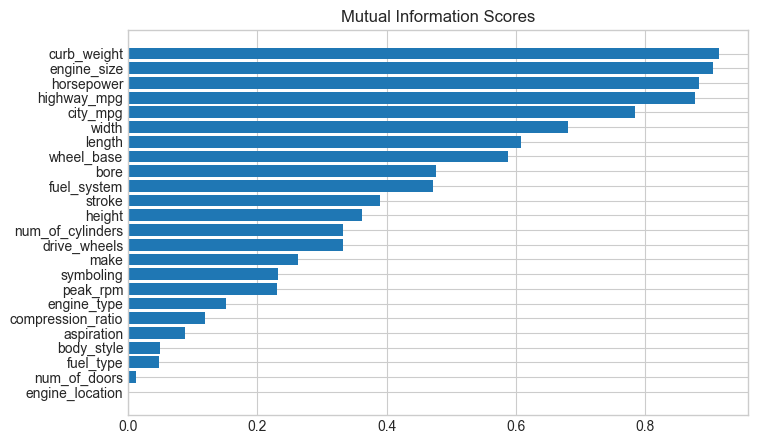

In [197]:
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

In [198]:
auto.head()

,symboling,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,width,height,curb_weight,engine_type,num_of_cylinders,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,4,130,mpfi,3.47,2.68,9,111,5000,21,27,13495
1,3,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,4,130,mpfi,3.47,2.68,9,111,5000,21,27,16500
2,1,alfa-romero,gas,std,2,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,6,152,mpfi,2.68,3.47,9,154,5000,19,26,16500
3,2,audi,gas,std,4,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,4,109,mpfi,3.19,3.40,10,102,5500,24,30,13950
4,2,audi,gas,std,4,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,5,136,mpfi,3.19,3.40,8,115,5500,18,22,17450


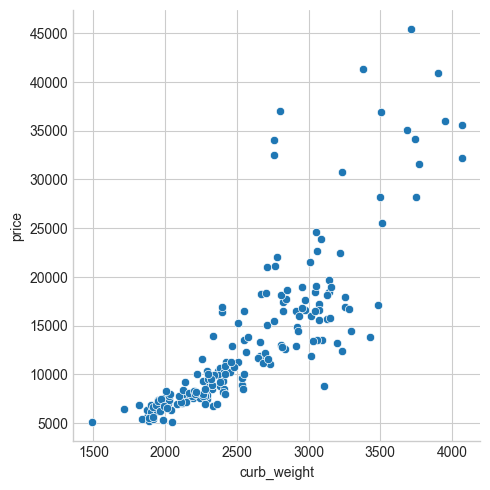

In [205]:
sns.relplot(x="curb_weight", y="price", data=auto)
plt.show()

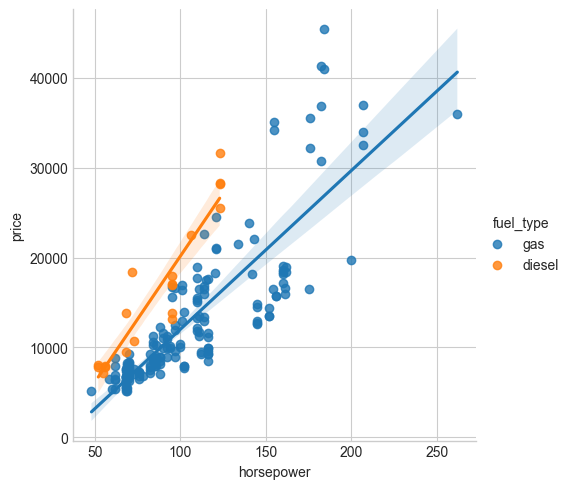

In [204]:
sns.lmplot(x="horsepower", y="price", hue="fuel_type", data=auto)
plt.show()